## Houston Neighborhood

This study will be focused on analyzing Houston Neighborhood in order to start a restaurant business!

In [47]:
# Import all libraries
import numpy as np
import pandas as pd
import json
import geopandas as gpd
from geopy.geocoders import Nominatim
import requests
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import folium
from bs4 import BeautifulSoup
import geocoder
import random
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [116]:
plt.rcParams.update({'font.size': 12})

## Read Wikipedia Page Houston Neighborhood

In [49]:
page = requests.get('https://en.wikipedia.org/wiki/List_of_Houston_neighborhoods')

In [50]:
# Call beautiful soup to parse wikipedia page
soup = BeautifulSoup(page.content, 'html.parser')

In [51]:
# Find all table in wikipedia page
tables = soup.findAll('table')

In [52]:
print('Total Number of tables in wikipedia: ' + str(len(tables)))

Total Number of tables in wikipedia: 4


In [54]:
# Get table that has information about Houston Neighborhood names
houston_table = soup.find('table', class_='wikitable')

## Read Table and Create a DataFrame

In [55]:
# Read the table from wikipedia
# Let's create a dictionary to hold neighborhood name and location side
name_dict = {'Neighborhood': [], 'Location_Side': []}

for row in houston_table.findAll('tr'):
    cells = row.findAll('td')
    if len(cells) > 0:
        name_dict['Neighborhood'].append(cells[1].find(text=True).replace('\n', '').replace('\n', ''))
        name_dict['Location_Side'].append(cells[2].find(text=True).replace('\n', ''))

# Create a dataframe neighborhood using name_dict
neighborhood = pd.DataFrame(name_dict)

In [56]:
neighborhood.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88 entries, 0 to 87
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Neighborhood   88 non-null     object
 1   Location_Side  88 non-null     object
dtypes: object(2)
memory usage: 1.5+ KB


In [57]:
neighborhood.head()

,Neighborhood,Location_Side
0,Willowbrook,Northwest
1,Greater Greenspoint,North
2,Carverdale,Northwest
3,Fairbanks,Northwest
4,Greater Inwood,Northwest


There are 88 neighborhood in Houston as per the table in wikipedia

## Function to get longitude and latitude of neighborhood

In [58]:
def long_lat(nhood):
    if 'Greater' in nhood:
        nhood = nhood.split('Greater ')[1]
    if 'formerly' in nhood:
        nhood = nhood.split(' (formerly')[0]
        
    try:
        address = nhood + ', Houston, TX'
        geolocator = Nominatim(user_agent='foursquare_agent')
        location = geolocator.geocode(address)
        latitude = location.latitude
        longitude = location.longitude
    except:
        latitude = np.nan
        longitude = np.nan
    
    # return tuple containing longitude and latitude
    return (longitude, latitude)

## Get Longitude and Latitude for Neighborhood

In [61]:
neighborhood['LongLat'] = neighborhood['Neighborhood'].apply(long_lat)
neighborhood['Neighborhood_Longitude'] = neighborhood['LongLat'].apply(lambda x: x[0])
neighborhood['Neighborhood_Latitude'] = neighborhood['LongLat'].apply(lambda x: x[1])
neighborhood.drop(columns=['LongLat'], inplace=True)

In [62]:
# neighborhood dataframe information
neighborhood.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88 entries, 0 to 87
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Neighborhood            88 non-null     object 
 1   Location_Side           88 non-null     object 
 2   Neighborhood_Longitude  67 non-null     float64
 3   Neighborhood_Latitude   67 non-null     float64
dtypes: float64(2), object(2)
memory usage: 2.9+ KB


Using Geopy geocoder (Nomanatim), we could only get longitude and latitude for 67 neighborhoods. 

## Create separate dataframes one that has longitude and latitude and the other one that has Null for longitude and latitude

In [63]:
longlat_present = neighborhood.dropna().reset_index(drop=True)
longlat_na = neighborhood[neighborhood['Neighborhood_Latitude'].isna()].reset_index(drop=True)

In [64]:
# Get names of neighborhood for which we could not get longitude and latitude
names_na = list(longlat_na['Neighborhood'])
names_na

['Addicks / Park Ten',
 'Lazybrook / Timbergrove',
 'Eldridge / West Oaks',
 'Briar Forest',
 'Mid-West (formerly Woodlake/Briarmeadow)',
 'Neartown',
 'University Place',
 'Brays Oaks (formerly Greater Fondren S.W.)',
 'Willow Meadows / Willowbend',
 'Northside / Northline',
 'East Little York / Homestead',
 'Northside Village',
 'El Dorado / Oates Prairie',
 'Hunterwood',
 'Fourth Ward',
 'Museum Park',
 'Greater OST / South Union',
 'Gulfgate Riverview / ',
 'Golfcrest / Bellfort / Reveille',
 'South Acres / Crestmont Park',
 'South Belt / Ellington']

## Create Map of Houston

In [65]:
address = 'Houston, TX'
geolocator = Nominatim(user_agent='foursquare_agent')
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

In [66]:
# Map of Houston
map_houston = folium.Map(location=[latitude, longitude], zoom_start=9)

for lat, lon, nhood in zip(longlat_present['Neighborhood_Latitude'], 
                           longlat_present['Neighborhood_Longitude'], longlat_present['Neighborhood']):
    label = folium.Popup(str(nhood), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        fill=True,
        fill_opacity=0.7).add_to(map_houston)

# Show map
map_houston

Based on above created map using 67 locations for which we have longitude and latitude, there are many locations for which the location information acquired by using Nominatim is incorrect.

In [283]:
map_houston.save('Map_First.png')

In [70]:
# Names of neighborhood with in-correct longitude and latitude
names_incorrect = ['Westchase', 'Greater Inwood', 'Jensen', 'Clear Lake', 'IAH Airport', 'Pecan Park',
                  'Westbury', 'South Main', 'Greater Eastwood', 'Greater Heights', 'Medical Center', 'Downtown', 
                  'Memorial', 'Spring Branch East', 'Midtown', 'Kingwood', 'Alief', 'Westwood', 
                  'Harrisburg', 'Braeburn', 'Sunnyside', 'Central Southwest', 'Greater Uptown', 
                  'Hidden Valley', 'Lawndale / Wayside', 'Second Ward', 'Greater Third Ward', 
                  'Greater Fifth Ward', 'Lake Houston']

print('Total number of incorrect locations:', len(names_incorrect))

Total number of incorrect locations: 29


Altogether we need to manually find longitude and latitude of 50 neighborhood (29 + 21)

In [72]:
# List of all Neighborhoods which require manual input for longitude and latitude
names = names_na + names_incorrect
print(sorted(names))

['Addicks / Park Ten', 'Alief', 'Braeburn', 'Brays Oaks (formerly Greater Fondren S.W.)', 'Briar Forest', 'Central Southwest', 'Clear Lake', 'Downtown', 'East Little York / Homestead', 'El Dorado / Oates Prairie', 'Eldridge / West Oaks', 'Fourth Ward', 'Golfcrest / Bellfort / Reveille', 'Greater Eastwood', 'Greater Fifth Ward', 'Greater Heights', 'Greater Inwood', 'Greater OST / South Union', 'Greater Third Ward', 'Greater Uptown', 'Gulfgate Riverview / ', 'Harrisburg', 'Hidden Valley', 'Hunterwood', 'IAH Airport', 'Jensen', 'Kingwood', 'Lake Houston', 'Lawndale / Wayside', 'Lazybrook / Timbergrove', 'Medical Center', 'Memorial', 'Mid-West (formerly Woodlake/Briarmeadow)', 'Midtown', 'Museum Park', 'Neartown', 'Northside / Northline', 'Northside Village', 'Pecan Park', 'Second Ward', 'South Acres / Crestmont Park', 'South Belt / Ellington', 'South Main', 'Spring Branch East', 'Sunnyside', 'University Place', 'Westbury', 'Westchase', 'Westwood', 'Willow Meadows / Willowbend']


In [73]:
# Setting incorrect location longitude and latitude to null
for index, row in neighborhood.iterrows():
    if row['Neighborhood'] in names_incorrect:
        neighborhood.loc[index, 'Neighborhood_Longitude'] = np.nan
        neighborhood.loc[index, 'Neighborhood_Latitude'] = np.nan

In [74]:
neighborhood.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88 entries, 0 to 87
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Neighborhood            88 non-null     object 
 1   Location_Side           88 non-null     object 
 2   Neighborhood_Longitude  38 non-null     float64
 3   Neighborhood_Latitude   38 non-null     float64
dtypes: float64(2), object(2)
memory usage: 2.9+ KB


In [75]:
# Saving neighborhood dataframe to excel file
neighborhood.sort_values(by='Neighborhood', ascending=True).to_excel('Neighborhood_Houston_out.xlsx', index=False)

Missing Longitude and Latitude values are filled up manually in Neighborhood_Houston_out.xlsx by searching the values in google search. The updated excel was saved as Neighborhood_Houston.xlsx

## Read Neighborhood_Houston.xlsx as neighborhood dataframe and use it for further analysis

In [76]:
neighborhood = pd.read_excel('Neighborhood_Houston.xlsx')

In [77]:
neighborhood.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88 entries, 0 to 87
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Neighborhood            88 non-null     object 
 1   Location_Side           88 non-null     object 
 2   Neighborhood_Longitude  88 non-null     float64
 3   Neighborhood_Latitude   88 non-null     float64
dtypes: float64(2), object(2)
memory usage: 2.9+ KB


In [78]:
neighborhood.nunique()

Neighborhood              88
Location_Side              9
Neighborhood_Longitude    86
Neighborhood_Latitude     87
dtype: int64

## Map of Houston with updated Co-ordinates

In [79]:
map_houston = folium.Map(location=[latitude, longitude], zoom_start=9)

for lat, lon, nhood in zip(neighborhood['Neighborhood_Latitude'], 
                           neighborhood['Neighborhood_Longitude'], neighborhood['Neighborhood']):
    label = folium.Popup(str(nhood), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        fill=True,
        fill_opacity=0.7).add_to(map_houston)

# Show map
map_houston

## Define FourSquare Credentials

In [80]:
CLIENT_ID = 'K2KJC5IP2ZFNPEX2FBGP4J5XLGD0WRGXSPNFV0DZ0F5AF2QH' # your Foursquare ID
CLIENT_SECRET = 'T41BPP5N5D1V3IXVG43V3W13EPDHHUBYOBREVLBSSTGSNCTD' # your Foursquare Secret
VERSION = '20200605' # Foursquare API version
LIMIT = 100

## Explore Neighborhoods in Houston

In [81]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    '''Function to get venues around neighborhood'''
    
    venues_list = []
    
    for name, lat, lng in zip(names, latitudes, longitudes):
        # Create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        # Make the get reguest
        results = requests.get(url).json()['response']['groups'][0]['items']
        
        # Returning only relevant information for each nearby venue for analysis
        venues_list.append([[name, lat, lng, 
                             v['venue']['name'], v['venue']['categories'][0]['name']] for v in results])
        
    venues_info = pd.DataFrame([row for venue_list in venues_list for row in venue_list],
                              columns=['Neighborhood Name', 'Latitude', 'Longitude', 'Venue', 'Category'])
    
    return venues_info

In [82]:
houston_venues = getNearbyVenues(neighborhood['Neighborhood'], neighborhood['Neighborhood_Latitude'], 
                                 neighborhood['Neighborhood_Longitude'])

In [83]:
# Print all the categories
print(sorted(houston_venues['Category'].unique()))

['ATM', 'Accessories Store', 'Afghan Restaurant', 'African Restaurant', 'Airport', 'Airport Lounge', 'Airport Service', 'Airport Terminal', 'American Restaurant', 'Antique Shop', 'Aquarium', 'Argentinian Restaurant', 'Art Gallery', 'Art Museum', 'Arts & Crafts Store', 'Arts & Entertainment', 'Asian Restaurant', 'Athletics & Sports', 'Auto Dealership', 'Auto Garage', 'Automotive Shop', 'BBQ Joint', 'Bagel Shop', 'Bakery', 'Bank', 'Bar', 'Baseball Field', 'Baseball Stadium', 'Basketball Court', 'Basketball Stadium', 'Beer Bar', 'Beer Garden', 'Beer Store', 'Big Box Store', 'Bike Shop', 'Bike Trail', 'Bistro', 'Bookstore', 'Border Crossing', 'Botanical Garden', 'Boutique', 'Brazilian Restaurant', 'Breakfast Spot', 'Brewery', 'Bridal Shop', 'Bubble Tea Shop', 'Building', 'Burger Joint', 'Burrito Place', 'Bus Station', 'Bus Stop', 'Business Service', 'Butcher', 'Café', 'Cajun / Creole Restaurant', 'Caribbean Restaurant', 'Casino', 'Check Cashing Service', 'Chinese Restaurant', 'Churrascaria

As you can see there are many categories which are similar in nature but the name are different. Next I will replace such categories with same name as it will make the analysis more accurate.

In [84]:
houston_venues['Category'].replace({'Aquarium': 'Aquarium & Zoo', 'Boutique': 'Store', 'Fruit & Vegetable Store': 'Store','Farmers Market': 'Market', 
                                    'Grocery Store': 'Market', 'Supermarket': 'Market', 'Dessert Shop': 'Cafe', 
                                   'Indie Movie Theater': 'Arts & Entertainment', 'Indie Theater': 'Arts & Entertainment', 
                                    "Men's Store": 'Store', "Women's Store": 'Store', 'Department Store':'Market', 
                                   'Zoo': 'Aquarium & Zoo', 'Performing Arts Venue': 'Arts & Entertainment', 'Casino': 'Arts & Entertainment', 
                                   'Movie Theater': 'Arts & Entertainment', 'Motel': 'Hotel', 'Concert Hall': 'Arts & Entertainment',
                                   'Kids Store': 'Store', 'Toy / Game Store': 'Store', 'Cosmetics Shop': 'Store', 'Electronics Store': 'Store', 
                                   'Bus Station': 'Station', 'Train Station': 'Station', 'Smoke Shop': 'Store', 
                                    'Paper / Office Supplies Store': 'Store', 'Science Museum': 'Museum', 'Bookstore': 'College Place', 
                                   'Bar': 'Club & Bar', 'Beer Bar': 'Club & Bar', 'Hookah Bar': 'Club & Bar', 
                                   'Music Store': 'Store', 'Shoe Store': 'Store', 'Piano Bar': 'Club & Bar', 'Hotel Bar': 'Club & Bar', 
                                   'Dive Bar': 'Club & Bar', 'Gay Bar': 'Club & Bar' , 'Nightclub': 'Club & Bar', 
                                   'Pub': 'Club & Bar', 'Rock Club': 'Club & Bar', 'Sports Bar': 'Club & Bar', 
                                   'Whisky Bar': 'Club & Bar', 'Wine Bar': 'Club & Bar', 'Cocktail Bar': 'Club & Bar', 
                                   'General Entertainment': 'Arts & Entertainment', 'Residential Building (Apartment / Condo)': 'Building / Office', 
                                   'Discount Store': 'Store', 'Hardware Store': 'Store', 'Gift': 'Store', 
                                   'Cosmetics': 'Health & Beauty Service', 'Public Art': 'Arts & Entertainment', 
                                   'Massage Studio': 'Health & Beauty Service', 'Spa': 'Health & Beauty Service', 
                                   'Thrift / Vintage Store': 'Store', 'Video Store': 'Store', 'Video Game Store': 'Store', 
                                   'Nail Salon': 'Health & Beauty Service', 'Theater': 'Arts & Entertainment', 
                                   'ATM': 'Bank', 'Auto Dealership': 'Auto Shop', 'Auto Garage': 'Auto Shop', 'Automotive Shop': 'Auto Shop', 
                                   'Café': 'Cafe', 'Coffee Shop': 'Cafe', 'Cupcake Shop': 'Cafe', 'Donut Shop': 'Cafe', 
                                   'College Baseball Diamond': 'College Place', 'College Residence Hall': 'College Place', 
                                    'College Theater': 'College Place', 'Bagel Shop': 'Cafe', 'Bakery': 'Cafe', 
                                   'Art Gallery': 'Museum', 'Art Museum': 'Museum', 'Other Repair Shop': 'Auto Shop', 
                                    'Arts & Crafts Store': 'Store', 'Baseball Field' : 'Stadium / Ground', 
                                    'Baseball Stadium': 'Stadium / Ground', 'Basketball Court': 'Stadium / Ground', 
                                    'Basketball Stadium': 'Stadium / Ground', 'Bubble Tea Shop': 'Cafe', 
                                   "Dentist's Office": 'Building / Office', "Doctor's Office": 'Building / Office', 'Building': 'Building / Office',
                                   'Fish Market': 'Market', 'Flea Market': 'Market', 'Flower Shop': 'Store', 
                                   'Antique Shop': 'Store', 'Bridal Shop': 'Store', 'Butcher': 'Store', 
                                   'Beer Store': 'Store', 'Big Box Store': 'Store', 'Bike Shop': 'Store', 
                                   'Comic Shop': 'Store', 'Costume Shop': 'Store', 'Football Stadium': 'Stadium / Ground', 
                                   'Furniture / Home Store': 'Store', 'Gaming Cafe': 'Arts & Entertainment', 'Go Kart Track': 'Arts & Entertainment', 
                                   'Gas Station': 'Store', 'General Travel': 'Store', 'Yoga Studio': 'Community Activities',
                                   'Fabric Shop': 'Store', 'Gift Shop': 'Store', 'Gourmet Shop': 'Store', 'Government Building': 'Building / Office', 
                                    'Office': 'Building / Office', 'Hobby Shop': 'Store', 'Accessories Store': 'Store', 
                                    'History Museum': 'Museum', 'Ice Cream Shop': 'Eat / Drink Bar', 'Juice Bar': 'Eat / Drink Bar', 
                                    'Jewelry Store': 'Store', 'Karaoke Bar': 'Club & Bar', 'Insurance Office': 'Building / Office', 
                                    'Frozen Yogurt Shop': 'Eat / Drink Bar', 'Lingerie Store': 'Store', 'Liquor Store': 'Store', 
                                    'Motorcycle Shop': 'Auto Shop', 'Motorsports Shop': 'Auto Shop', 'Historic Site': 'Site View', 
                                    'Monument / Landmark': 'Site View', 'Mattress Store': 'Store', 'Medical Supply Store': 'Store',
                                    'Miscellaneous Shop': 'Store', 'Mobile Phone Shop': 'Store', 'Night Market': 'Market', 
                                    'Optical Shop': 'Store', 'Outdoor Sculpture': 'Site View', 'Outdoors & Recreation': 'Site View', 
                                    'Print Shop': 'Store', 'Record Shop': 'Store', 'Resort': 'Hotel', 'Salon / Barbershop': 'Health & Beauty Service', 
                                    'Scenic Lookout': 'Site View', 'Sculpture Garden': 'Site View', 'Pharmacy': 'Building / Office', 
                                    'Opera House': 'Arts & Entertainment', 'Skate Park': 'Site View', 'Smoothie Shop': 'Eat / Drink Bar', 
                                    'Shipping Store': 'Store', 'Shop': 'Store', 'Shop & Service': 'Store', 'Skate Park': 'Site View', 
                                    'Soccer Field': 'Stadium / Ground', 'Soccer Stadium': 'Stadium / Ground', 'Student Center': 'College Place', 
                                    'Sporting Goods Shop': 'Store', 'Tanning Salon': 'Health & Beauty Service', 'Tennis Court': 'Stadium / Ground', 
                                    'Track': 'Stadium / Ground', 'Track Stadium': 'Stadium / Ground', 'Volleyball Court': 'Stadium / Ground', 
                                    'Warehouse Store': 'Store', 'Water Park': 'Arts & Entertainment', 'Zoo Exhibit': 'Aquarium & Zoo', 
                                    'Pet Store': 'Store', 'Supplement Shop': 'Store', 'Tattoo Parlor': 'Health & Beauty Service', 
                                    'Theme Park': 'Site View', 'Theme Park Ride / Attraction': 'Site View', 'Music Venue': 'Arts & Entertainment', 
                                    'Botanical Garden': 'Site View', 'Check Cashing Service': 'Store', 
                                    'Currency Exchange': 'Store', 
                                    'Park': 'Site View', 'Assisted Living': 'Building / Office', 'Brewery': 'Club & Bar', 
                                    'Community Center': 'Community Activities', 'Cycle Studio': 'Community Activities', 
                                    'Dance Studio': 'Community Activities', 'Event Service': 'Community Activities', 'Gun Range': 'Arts & Entertainment',
                                    'Exhibit': 'Community Activities', 'Spiritual Center': 'Community Activities', 'Plaza': 'Shopping Mall', 
                                    'Construction & Landscaping': 'Building / Office', 'Lake': 'Site View', 'Planetarium': 'Arts & Entertainment', 
                                    'Bus Stop': 'Station', 'Comedy Club': 'Arts & Entertainment', 'Eye Doctor': 'Building / Office', 
                                    'Library': 'College Place', 'Outdoor Supply Store': 'Store', 'Tea Room': 'Cafe',
                                    'Playground': 'Stadium / Ground', 'Clothing Store': 'Store', 'Convenience Store': 'Store',
                                    'Hospital': 'Building / Office'
                                   }, inplace=True)

# Combine Hot Encoded data with houston_venues

In [85]:
# One Hot Encoder in Category
cat_encode = pd.get_dummies(houston_venues['Category'])

# Combine Hot Encoded data with houston_venues
houston_venues_encode = pd.concat([houston_venues, cat_encode], axis=1)

In [86]:
houston_venues_encode.head()

,Neighborhood Name,Latitude,Longitude,Venue,Category,Afghan Restaurant,African Restaurant,Airport,Airport Lounge,Airport Service,...,Thai Restaurant,Theme Restaurant,Tourist Information Center,Trail,Travel & Transport,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Weight Loss Center,Wings Joint
0,Acres Home,29.770793,-95.328129,Silo,Arts & Entertainment,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Acres Home,29.770793,-95.328129,Frenchys Chicken,Fried Chicken Joint,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Acres Home,29.770793,-95.328129,The New Potato,Club & Bar,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Acres Home,29.770793,-95.328129,I10 and Waco,Intersection,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Acres Home,29.770793,-95.328129,Anjelica and Anjelique,Food,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## DataFrame based on category sum

In [200]:
col = list(houston_venues_encode.columns)

# Create new dataframe by grouping by Neighborhood and get sum of each category
venues_sum = houston_venues_encode.groupby('Neighborhood Name').agg({k: 'max' if k in ['Latitude', 'Longitude'] else 'sum' for k in col[1:3] + col [5:]}).reset_index()
#venues_sum = houston_venues_encode.groupby('Neighborhood Name')[col[1:3] + col[5:]].sum().reset_index()

col = list(houston_venues_encode.columns)

# Create new dataframe by grouping by Neighborhood and get frequency of each category
venues_freq = houston_venues_encode.groupby('Neighborhood Name')[col[1:3] + col[5:]].mean().reset_index()

# Create new dataframe by grouping by Neighborhood and get sum of each category
venues_sum = houston_venues_encode.groupby('Neighborhood Name')[col[1:3] + col[5:]].sum().reset_index()

In [201]:
# Get list of all venues
venues_col = list(venues_sum.columns[3:])
print(venues_col)
print('Total Unique Venues Type:', len(venues_col))

['Afghan Restaurant', 'African Restaurant', 'Airport', 'Airport Lounge', 'Airport Service', 'Airport Terminal', 'American Restaurant', 'Aquarium & Zoo', 'Argentinian Restaurant', 'Arts & Entertainment', 'Asian Restaurant', 'Athletics & Sports', 'Auto Shop', 'BBQ Joint', 'Bank', 'Beer Garden', 'Bike Trail', 'Bistro', 'Border Crossing', 'Brazilian Restaurant', 'Breakfast Spot', 'Building / Office', 'Burger Joint', 'Burrito Place', 'Business Service', 'Cafe', 'Cajun / Creole Restaurant', 'Caribbean Restaurant', 'Chinese Restaurant', 'Churrascaria', 'Club & Bar', 'College Place', 'Comfort Food Restaurant', 'Community Activities', 'Deli / Bodega', 'Diner', 'Dog Run', 'Dry Cleaner', 'Dumpling Restaurant', 'Duty-free Shop', 'Eat / Drink Bar', 'Empanada Restaurant', 'Escape Room', 'Ethiopian Restaurant', 'Fast Food Restaurant', 'Filipino Restaurant', 'Financial or Legal Service', 'Food', 'Food & Drink Shop', 'Food Court', 'Food Service', 'Food Truck', 'French Restaurant', 'Fried Chicken Joint'

## Popular / Important Venues
Important venues which attract more people. Based on these venues further analysis is performed

In [202]:
imp_venues = ['Arts & Entertainment', 'Aquarium & Zoo', 'Auto Shop','Bank','Building / Office', 
              'Community Activities', 'College Place', 'Health & Beauty Service', 
              'Market', 'Museum', 'Shopping Mall', 'Stadium / Ground', 'Station', 'Store']
print('Total number of important venues selected:', len(imp_venues))

Total number of important venues selected: 14


## Separate Restaurant data and Popular venues data

In [203]:
# Getting all restaurant 
restaurant_type = [i for i in venues_col if ('restaurant' in i.lower() or 'food' in i.lower() or 'diner' in i.lower() 
                                            or 'bistro' in i.lower() or 'taco place' in i.lower() or 'pizza' in i.lower() 
                                            or 'noodle house' in i.lower() or 'wings joint' in i.lower() 
                                            or 'burrito place' in i.lower() or 'churrascaria' in i.lower() 
                                            or 'deli' in i.lower() or 'gastropub' in i.lower() 
                                            or 'snack place' in i.lower() or 'salad place' in i.lower() 
                                            or 'beer garden' in i.lower() or 'hot dog joint' in i.lower() 
                                            or 'mac & cheese' in i.lower() or 'steakhouse' in i.lower() 
                                            or 'sandwich place' in i.lower() or 'burger joint' in i.lower() 
                                            or 'bbq joint' in i.lower() or 'fried chicken' in i.lower())]

In [204]:
print('Total Restaurant type choosen:', len(restaurant_type))

Total Restaurant type choosen: 73


In [205]:
print(restaurant_type)

['Afghan Restaurant', 'African Restaurant', 'American Restaurant', 'Argentinian Restaurant', 'Asian Restaurant', 'BBQ Joint', 'Beer Garden', 'Bistro', 'Brazilian Restaurant', 'Burger Joint', 'Burrito Place', 'Cajun / Creole Restaurant', 'Caribbean Restaurant', 'Chinese Restaurant', 'Churrascaria', 'Comfort Food Restaurant', 'Deli / Bodega', 'Diner', 'Dumpling Restaurant', 'Empanada Restaurant', 'Ethiopian Restaurant', 'Fast Food Restaurant', 'Filipino Restaurant', 'Food', 'Food & Drink Shop', 'Food Court', 'Food Service', 'Food Truck', 'French Restaurant', 'Fried Chicken Joint', 'Gastropub', 'Greek Restaurant', 'Hawaiian Restaurant', 'Himalayan Restaurant', 'Hot Dog Joint', 'Hunan Restaurant', 'Indian Chinese Restaurant', 'Indian Restaurant', 'Italian Restaurant', 'Japanese Restaurant', 'Korean Restaurant', 'Latin American Restaurant', 'Mac & Cheese Joint', 'Mediterranean Restaurant', 'Mexican Restaurant', 'Middle Eastern Restaurant', 'New American Restaurant', 'Noodle House', 'Pakista

[i for i in venues_col if i not in imp_venues + restaurant_type]

## Two DataFrames: One for restaurant and next one for popular venues

In [206]:
restaurant_df = venues_sum[col[:3] + restaurant_type].copy()
popular_df = venues_sum[col[:3] + imp_venues].copy()

In [207]:
# Check Restaurant_df
restaurant_df.head()

,Neighborhood Name,Latitude,Longitude,Afghan Restaurant,African Restaurant,American Restaurant,Argentinian Restaurant,Asian Restaurant,BBQ Joint,Beer Garden,...,Szechuan Restaurant,Taco Place,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Theme Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint
0,Acres Home,29.770793,-95.328129,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Addicks / Park Ten,29.813300,-95.645500,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Afton Oaks,29.731787,-95.450647,0,0,2,0,0,1,0,...,0,0,0,0,2,0,0,0,0,0
3,Alief,29.682700,-95.593200,0,0,0,0,0,0,0,...,0,2,0,0,0,0,0,0,0,0
4,Astrodome Area,29.685230,-95.403468,0,0,0,0,0,2,0,...,0,0,0,0,0,0,0,0,0,0


In [208]:
# Check popular_df
popular_df.head()

,Neighborhood Name,Latitude,Longitude,Arts & Entertainment,Aquarium & Zoo,Auto Shop,Bank,Building / Office,Community Activities,College Place,Health & Beauty Service,Market,Museum,Shopping Mall,Stadium / Ground,Station,Store
0,Acres Home,29.770793,-95.328129,2,0,0,0,0,0,0,0,1,0,0,0,0,0
1,Addicks / Park Ten,29.813300,-95.645500,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,Afton Oaks,29.731787,-95.450647,2,0,0,0,0,0,0,1,0,0,0,0,0,5
3,Alief,29.682700,-95.593200,0,0,0,0,0,0,0,0,1,0,0,0,0,3
4,Astrodome Area,29.685230,-95.403468,3,0,0,0,1,0,0,1,0,0,0,5,0,5


## Apply K-Mean Algorithm

Text(0, 0.5, 'WCSS')

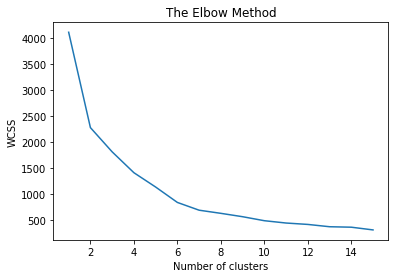

In [209]:
# List for within Cluster Sum of Squares for different cluster. Initially empty list
wcss = []
for i in range(1, 16):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 500)
    kmeans.fit(popular_df.drop(columns=['Neighborhood Name', 'Latitude', 'Longitude']))
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 16), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

The Elbow Method show WCSS showing decreasing trend even at n_cluster = 15. Since, we do not want to have high number of cluster. For the purpose of applying KMeans, n = 6 will be used. As as compared with n = 1, at n = 5, wcss almost get down by 1/3rd.

In [210]:
kmeans = KMeans(n_clusters=6, init='k-means++', random_state=500)
kmeans.fit(popular_df.drop(columns=['Neighborhood Name', 'Latitude', 'Longitude']))

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=6, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=500, tol=0.0001, verbose=0)

In [211]:
# Finding Label for each row
popular_df['Label'] = kmeans.labels_
restaurant_df['Label'] = kmeans.labels_

In [212]:
# Map of Houston
map_houston = folium.Map(location=[latitude, longitude], zoom_start=9)
# Set color for clusters
colors = []

for i in range(8):
    col = []
    for j in range(6):
        x = random.choice('ABCDEF0123456789')
        col.append(x)
    col = ''.join(col)
    col = '#' + col
    colors.append(col)

print(colors)
for lat, lon, nhood, cluster in zip(popular_df['Latitude'], popular_df['Longitude'], popular_df['Neighborhood Name'], popular_df['Label']):
    label = folium.Popup(str(nhood) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=colors[cluster],
        fill=True,
        fill_color=colors[cluster],
        fill_opacity=0.7).add_to(map_houston)

# Show Map
map_houston

['#7EDE99', '#2A0B20', '#9BB0C7', '#1E5F62', '#6C0022', '#0E0A57', '#3633C4', '#497198']


In [213]:
popular_df.sort_values(by='Label', ascending=True)

,Neighborhood Name,Latitude,Longitude,Arts & Entertainment,Aquarium & Zoo,Auto Shop,Bank,Building / Office,Community Activities,College Place,Health & Beauty Service,Market,Museum,Shopping Mall,Stadium / Ground,Station,Store,Label
65,Pecan Park,29.596862,-95.673054,0,0,0,1,1,0,0,0,1,0,0,1,0,6,0
47,Langwood,29.826282,-95.482795,0,0,1,2,0,0,0,0,4,0,0,0,0,9,0
41,IAH Airport,29.983924,-95.332202,1,0,0,0,0,0,0,1,0,0,0,0,0,7,0
48,Lawndale / Wayside,29.724800,-95.311200,0,0,0,0,0,0,0,0,0,0,0,0,0,9,0
49,Lazybrook / Timbergrove,29.801600,-95.438100,0,0,0,0,1,0,0,1,0,0,1,0,0,6,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,Trinity / Houston Gardens,29.766979,-95.373908,10,1,1,0,0,3,0,0,1,4,0,1,1,4,4
57,Midtown,29.740800,-95.375600,6,0,0,0,0,2,0,3,2,3,0,0,0,5,4
81,Washington Avenue,29.766461,-95.367846,12,1,0,0,1,1,0,0,1,0,0,0,0,1,4
59,Museum Park,29.725900,-95.383200,5,0,0,1,1,1,0,2,1,13,1,0,0,10,4


## Create plots for label and popular venue categories

fig , axes = plt.subplots(nrows=6, ncols=3, figsize=(18,30))
for i, axs in enumerate(axes.flatten()):
    sns.catplot(x='Label', y=imp_venues[i], data=popular_df, ax=axs)
    #axs.set_title(imp_venues[i])

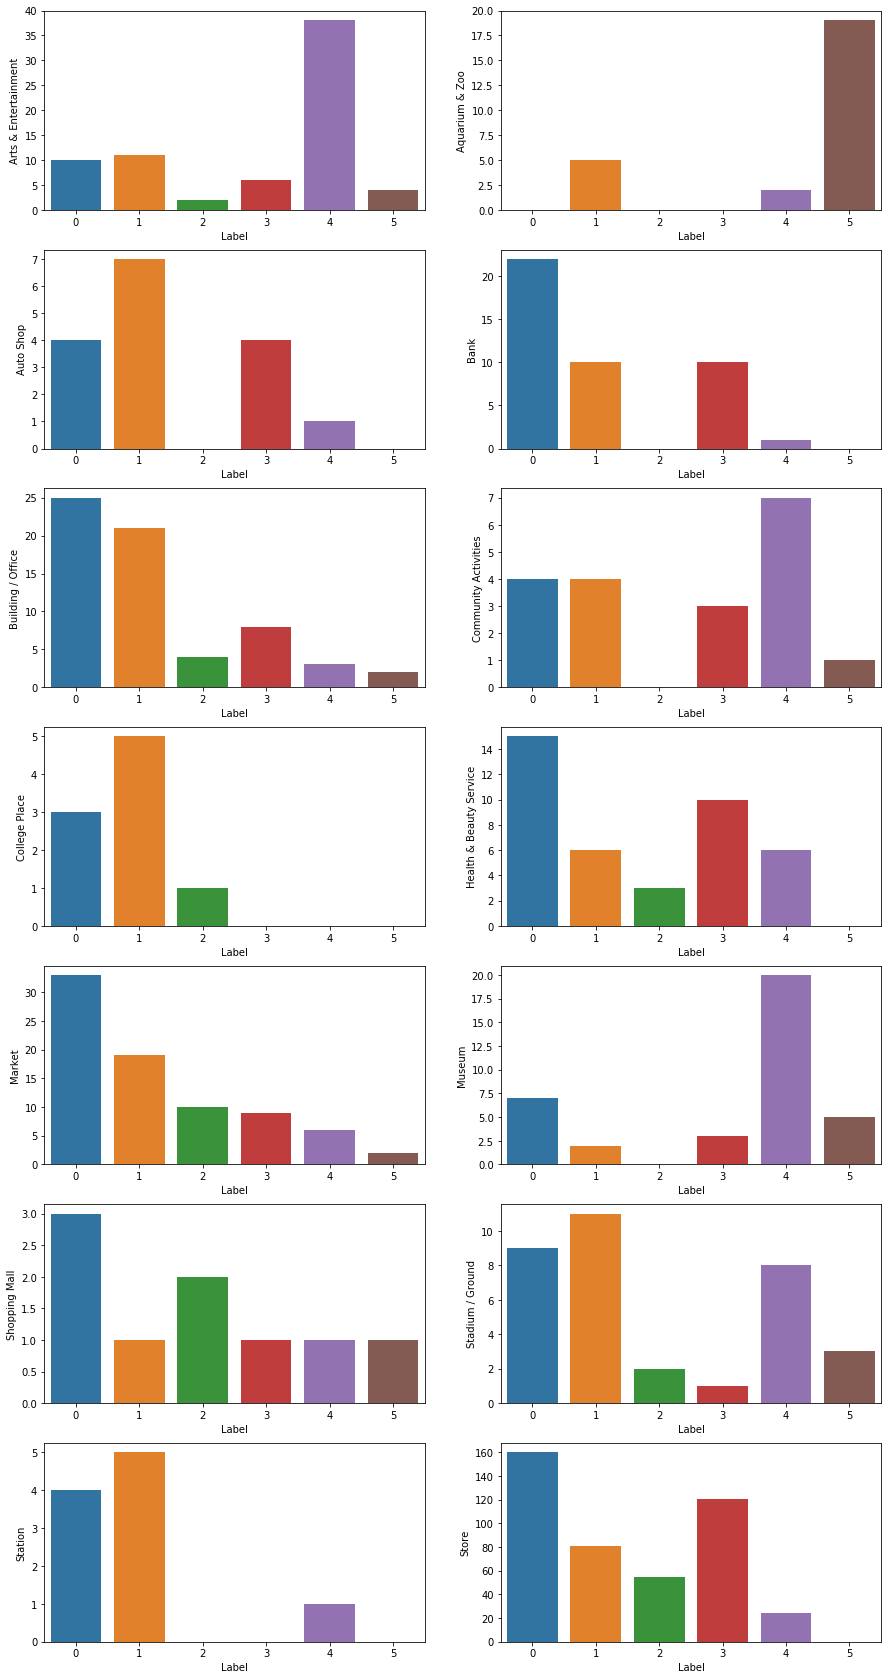

In [231]:
pop_gp = popular_df.groupby('Label')[popular_df.columns[3:17]].sum().reset_index()
fig , axes = plt.subplots(nrows=7, ncols=2, figsize=(15,30))
for i, axs in enumerate(axes.flatten()):
    sns.barplot(x='Label', y=imp_venues[i], data=pop_gp, ax=axs)

Based on label and number of popular sites, it seems all neighborhood with labels 0, 1, 3 and 4 should further investigate as these neighborhood has good numbers of popular sites around and will be perfect to analyze more to open a new restaurant.

## Restaurant Analysis in Neighborhood

In [262]:
restaurant_df = restaurant_df[restaurant_df['Label'].isin([0])].reset_index(drop=True)

In [263]:
restaurant_df.head()

,Neighborhood Name,Latitude,Longitude,Afghan Restaurant,African Restaurant,American Restaurant,Argentinian Restaurant,Asian Restaurant,BBQ Joint,Beer Garden,...,Taco Place,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Theme Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint,Label
0,Afton Oaks,29.731787,-95.450647,0,0,2,0,0,1,0,...,0,0,0,2,0,0,0,0,0,0
1,Astrodome Area,29.685230,-95.403468,0,0,0,0,0,2,0,...,0,0,0,0,0,0,0,0,0,0
2,Braeburn,29.676900,-95.528400,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Braeswood,29.678705,-95.478061,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
4,Brays Oaks (formerly Greater Fondren S.W.),29.655700,-95.528000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Restaurant Count in Neighborhood

In [264]:
# Total Number of restaurant in a neighborhood
restaurant_count = np.array(restaurant_df.drop(columns=['Neighborhood Name', 'Latitude', 
                                                       'Longitude', 'Label']).sum(axis=1))

In [265]:
restaurant_count = pd.Series(restaurant_count, index=restaurant_df['Neighborhood Name'])
restaurant_count = restaurant_count.reset_index()
restaurant_count.columns = ['Neighborhood Name', 'Total Restaurant']

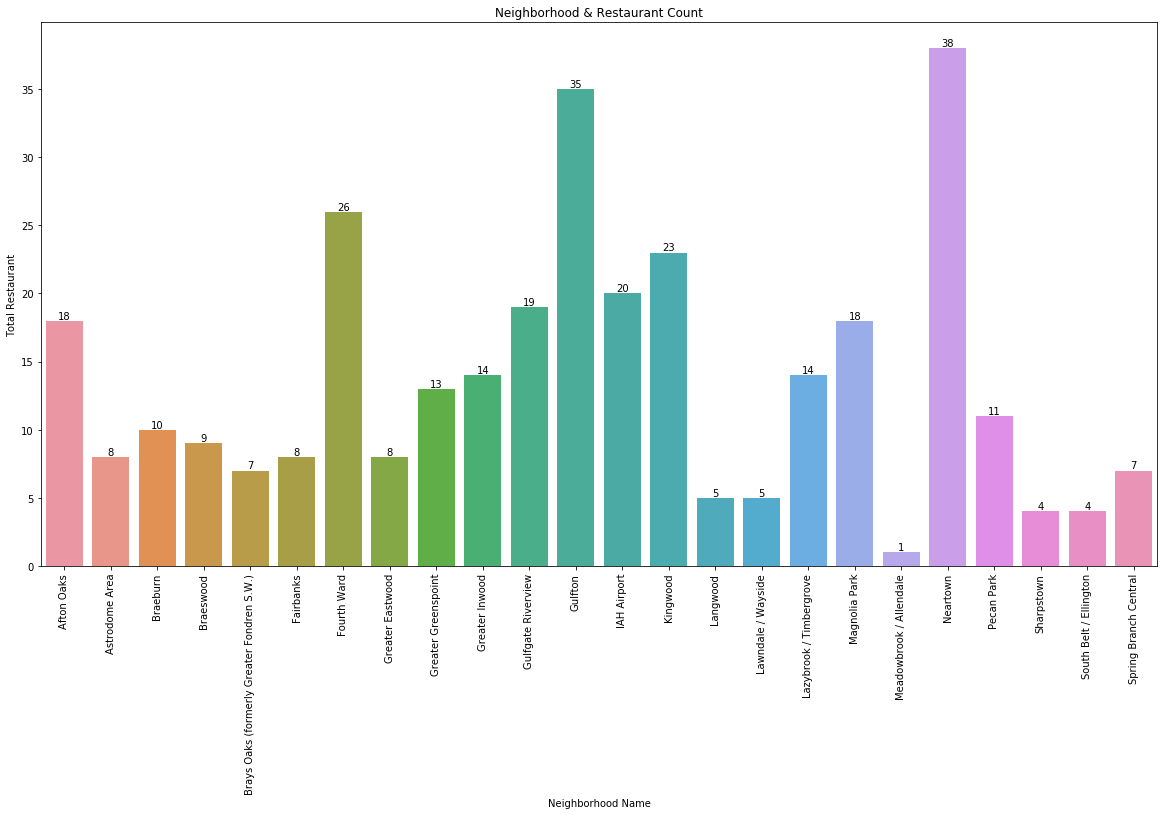

In [266]:
plt.figure(figsize=(20,10))
ax1 = sns.barplot(data=restaurant_count, x='Neighborhood Name', y='Total Restaurant')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
ax1.set_title('Neighborhood & Restaurant Count')
for obj in ax1.patches:
    h = int(obj.get_height())
    x = obj.get_x() + obj.get_width()/2
    ax1.annotate(s=str(h), xy=(x,h), va='bottom', ha='center')

## Focusing on neighborhood that has less than 10 restaurants

In [267]:
focus_neighborhood = list(restaurant_count[restaurant_count['Total Restaurant']<10]['Neighborhood Name'])
focus_neighborhood_df = restaurant_df[restaurant_df['Neighborhood Name'].isin(focus_neighborhood)].reset_index(drop=True)

In [268]:
focus_neighborhood_df.drop(columns=['Latitude', 'Longitude'], inplace=True)

In [269]:
focus_neighborhood_df

,Neighborhood Name,Afghan Restaurant,African Restaurant,American Restaurant,Argentinian Restaurant,Asian Restaurant,BBQ Joint,Beer Garden,Bistro,Brazilian Restaurant,...,Taco Place,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Theme Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint,Label
0,Astrodome Area,0,0,0,0,0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Braeswood,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,Brays Oaks (formerly Greater Fondren S.W.),0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Fairbanks,0,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,1,1,0
4,Greater Eastwood,0,0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,0
5,Langwood,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,Lawndale / Wayside,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
7,Meadowbrook / Allendale,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,Sharpstown,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,South Belt / Ellington,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [270]:
focus_neighborhood_df.set_index('Neighborhood Name', drop=True, inplace=True)

## Maximum number of same category restaurant in above 11 neighborhoods

In [271]:
max_sameCategory = focus_neighborhood_df.max(axis=1).reset_index()

In [272]:
max_sameCategory.head()

,Neighborhood Name,0
0,Astrodome Area,2
1,Braeswood,1
2,Brays Oaks (formerly Greater Fondren S.W.),2
3,Fairbanks,1
4,Greater Eastwood,2


In [279]:
print('Following Houston neighborhoods will be ideal to open a restaurant: ', list(max_sameCategory['Neighborhood Name']))

Following Houston neighborhoods will be ideal to open a restaurant:  ['Astrodome Area', 'Braeswood', 'Brays Oaks (formerly Greater Fondren S.W.)', 'Fairbanks', 'Greater Eastwood', 'Langwood', 'Lawndale / Wayside', 'Meadowbrook / Allendale', 'Sharpstown', 'South Belt / Ellington', 'Spring Branch Central']


In [280]:
max_sameCategory.rename(columns={0: 'Count'}, inplace=True)

Text(0.5, 1.0, 'Maximum Number of Same Category Restaurant')

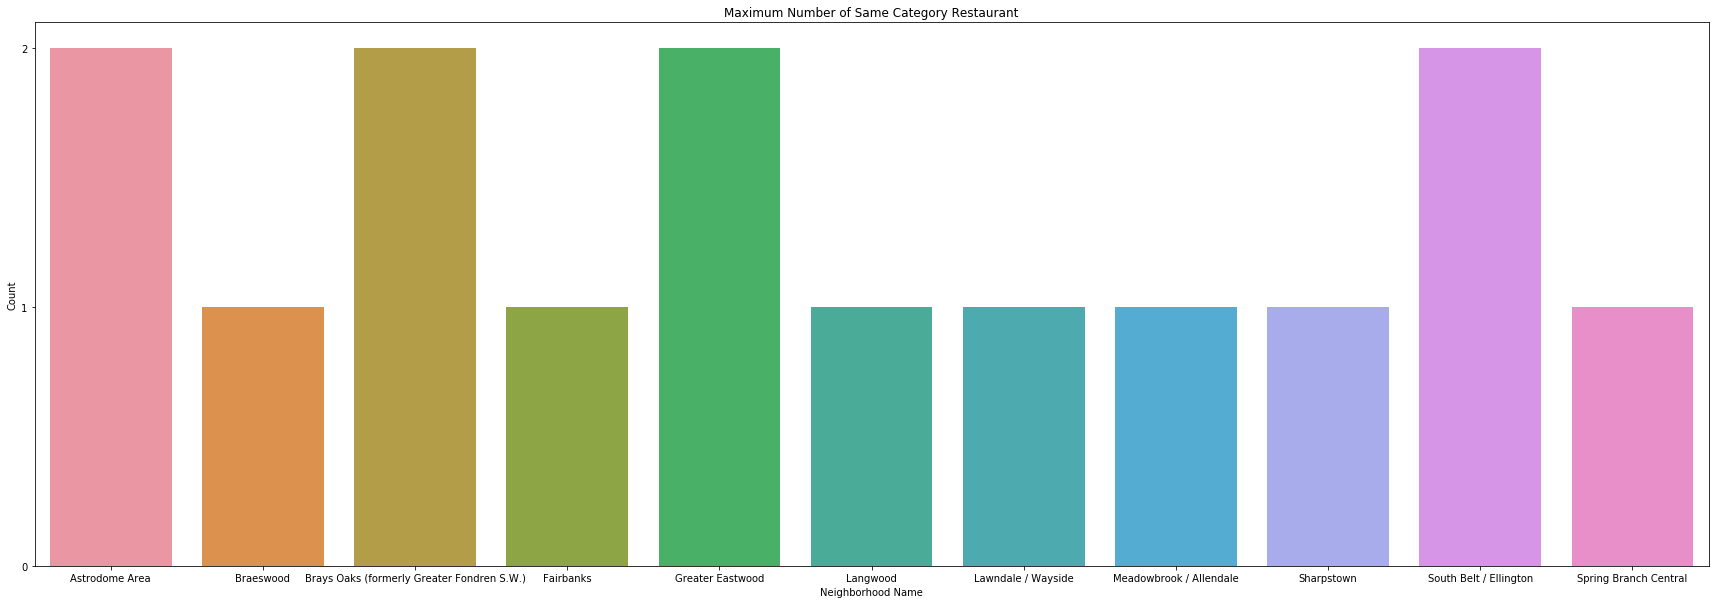

In [284]:
plt.rcParams.update({'font.size': 10})
plt.figure(figsize=(30, 10))
sns.barplot(x='Neighborhood Name', y = 'Count', data=max_sameCategory)
plt.yticks(np.arange(0,3))
plt.title('Maximum Number of Same Category Restaurant')

The maximum number of restaurant of same category is 2 in some neighborhoods that we focused. It's not a high number so we can say that all kinds of cuisine has high prospect of being successfull in those neighborhood.

## End